Imports

In [67]:
import perceval as pcvl
import os
import numpy as np
from perceval.components.unitary_components import BS, PERM, PS

We want to reproduce this circuit:

![](chsh.png)

Define input state and circuit:

In [68]:
input_state = pcvl.BasicState("|1,0,1,0>")

In [69]:
circuit = pcvl.Circuit(4)

The circuit starts with two 50/50 beam-splitters:

In [70]:
circuit.add(0, BS())
circuit.add(2, BS())

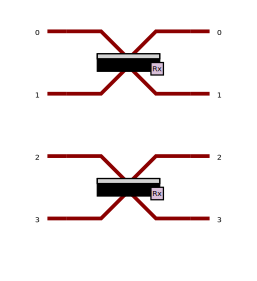

In [71]:
pcvl.pdisplay(circuit)

Then we have a permutation of modes. PERM is a simple perceval component:

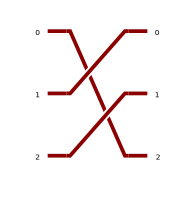

In [72]:
perm_example = PERM([2,0,1])
pcvl.pdisplay(perm_example)

Here we switch Alice's second mode with Bob's first mode:

In [73]:
circuit.add(0, PERM([0,2,1,3]))

How does it look so far?

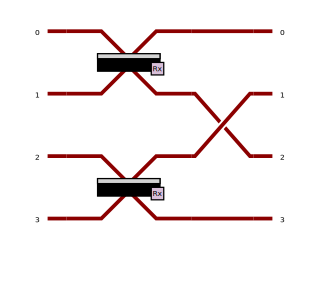

In [74]:
pcvl.pdisplay(circuit)

Now let's add the two interferometers that define the measurement bases. We keep the angles as parameters to be set during the Bell test.

In [75]:
psi_A = pcvl.P('psi_A')
psi_B = pcvl.P('psi_B')

circuit.add(0, PS(psi_A))
circuit.add(3, PS(psi_B))

In [76]:
circuit.add(0, BS())
circuit.add(2, BS())

In [77]:
phi_A = pcvl.P('phi_A')
phi_B = pcvl.P('phi_B')

circuit.add(0, PS(phi_A))
circuit.add(3, PS(phi_B))

In [78]:
circuit.add(0, BS())
circuit.add(2, BS())

How does it look now?

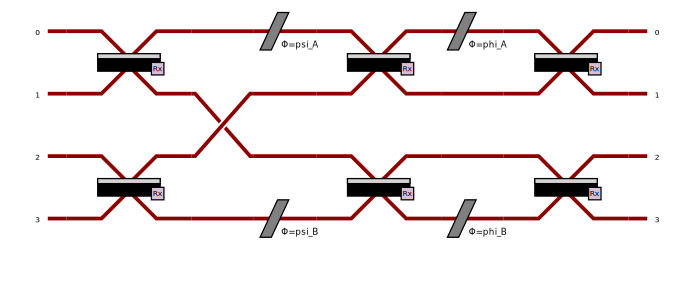

In [79]:
pcvl.pdisplay(circuit)

What are the angles needed for the CHSH measurements?

![](chsh_meas.png)

This means we can just set the psi angles to 0:

In [80]:
psi_A.set_value(0)
psi_B.set_value(0)

Let us define the processor and sampler for our simulation:

In [81]:
processor = pcvl.Processor("SLOS", circuit)

We have a post-selection rule in our dual rail encoding: there should be 1 photon in Alice's mode and 1 photon in Bob's modes:

In [82]:
post_selection_rule = pcvl.PostSelect("[0,1] == 1 & [2,3] == 1")
processor.set_postselection(post_selection_rule)

In [83]:
processor.with_input(input_state)

In [84]:
sampler = pcvl.algorithm.Sampler(processor)

And now let us run a sampling simulation for all the inputs of the Bell test:

In [85]:
total_samples = 10000

In [86]:
for x in [-np.pi/2, 0]:
    for y in [-np.pi/4, np.pi/4]:
        phi_A.set_value(x)
        phi_B.set_value(y)
        sample_count = sampler.sample_count(total_samples/4)
        print(sample_count['results'])

{
  |1,0,1,0>: 174
  |1,0,0,1>: 1092
  |0,1,1,0>: 1024
  |0,1,0,1>: 210
}
{
  |1,0,1,0>: 1054
  |1,0,0,1>: 178
  |0,1,1,0>: 195
  |0,1,0,1>: 1073
}
{
  |1,0,1,0>: 192
  |1,0,0,1>: 1069
  |0,1,1,0>: 1051
  |0,1,0,1>: 188
}
{
  |1,0,1,0>: 197
  |1,0,0,1>: 1071
  |0,1,1,0>: 1064
  |0,1,0,1>: 168
}


Those are just the raw results. Now we have to compute the CHSH expression.

Recall: $B_{CHSH} = |<A_1B_1> + <A_1B_2> + <A_2B_1> - <A_2B_2>|$

With $<A_xB_y> = p(00|xy) - p(01|xy) - p(10|xy) + p(11|xy)$

In [87]:
correlator_list = []

for x in [0, -np.pi/2]:
    for y in [-np.pi/4, np.pi/4]:
        phi_A.set_value(x)
        phi_B.set_value(y)
        sample_count = sampler.sample_count(total_samples/4)
        
        correlator = (sample_count['results'][pcvl.BasicState('|1,0,1,0>')] 
                      - sample_count['results'][pcvl.BasicState('|1,0,0,1>')]
                      - sample_count['results'][pcvl.BasicState('|0,1,1,0>')]
                      + sample_count['results'][pcvl.BasicState('|0,1,0,1>')])

        correlator = correlator/(total_samples/4)
        
        correlator_list.append(correlator)

In [88]:
correlator_list

[-0.6912, -0.7296, -0.7128, 0.7224]

In [89]:
CHSH = np.abs(correlator_list[0] + correlator_list[1] + correlator_list[2] - correlator_list[3])
CHSH

2.856

In [90]:
2*np.sqrt(2)

2.8284271247461903

We break the limit bc of statistical variance.